In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit.aqua import QuantumInstance
from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE, IQPE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import ExcitationPreserving

from qiskit.circuit.library import ExcitationPreserving

from qiskit.chemistry.core import ChemistryOperator

from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType
from qiskit.aqua.algorithms import VQAlgorithm, VQE, MinimumEigensolver
from qiskit.chemistry.qubit_transformations import FermionicTransformation
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.ground_state_calculation import MinimumEigensolverGroundStateCalculation

In [2]:
# import BOPES
from qiskit.chemistry.bopes_sampler import BOPESSampler

In [3]:
ft = FermionicTransformation()
driver = PySCFDriver()
solver = VQE(quantum_instance=
             QuantumInstance(backend=BasicAer.get_backend('statevector_simulator')))
#solver = NumPyMinimumEigensolver()
me_gsc = MinimumEigensolverGroundStateCalculation(ft, solver)

In [4]:
# import molecule 
from qiskit.chemistry.drivers.molecule import Molecule
from functools import partial

In [5]:
stretch1 = partial(Molecule.absolute_stretching, atom_pair=(1, 0))
mol = Molecule(geometry=[('H', [0., 0., 0.]),
                        ('H', [0., 0., 0.3])],
                       degrees_of_freedom=[stretch1],
                       )

# pass molecule to PSYCF driver
driver = PySCFDriver(molecule=mol)

In [6]:
# BOPES sampler testing
bs = BOPESSampler(gsc=me_gsc, driver=driver, 
                  bootstrap=True, num_bootstrap=3)
points = np.linspace(0.1,3,8)
bs_res_full, bs_res = bs.compute_surface(points)

In [7]:
bs_res_full[0.1]

{'raw_result': {'optimal_parameters': {Parameter(θ[0]): -0.019921922628228363, Parameter(θ[1]): 2.3819530246357403, Parameter(θ[2]): -1.1936647040170125, Parameter(θ[3]): -0.2655023909650996, Parameter(θ[4]): -2.7315700885937675, Parameter(θ[5]): 0.10015587897904374, Parameter(θ[6]): 0.8626286707628738, Parameter(θ[7]): -0.9913090347030158}, 'optimal_point': array([-0.01992192,  2.38195302, -1.1936647 , -0.26550239, -2.73157009,
         0.10015588,  0.86262867, -0.99130903]), 'optimal_value': -2.2370926496820736, 'optimizer_evals': 77, 'optimizer_time': 1.8427319526672363, 'eigenvalue': (-2.2370926496820736+0j), 'eigenstate': array([-2.03364438e-04+0.j, -9.98229836e-01+0.j,  5.94739424e-02+0.j,
        -5.40585456e-05+0.j]), 'aux_operator_eigenvalues': array([[1.999999999999999],
        [2.229224952e-08],
        [0.0],
        [0.0],
        [0.0],
        [0.7562657165144089]], dtype=object), 'cost_function_evals': 77},
 'eigenvalue': (-2.2370926496820736+0j),
 'aux_values': array(

In [8]:
energies = []
for point in points:
    energy = bs_res_full[point]['computed_electronic_energy'] + bs_res_full[point]['nuclear_repulsion_energy']
    energies.append(energy)

No handles with labels found to put in legend.


Text(0, 0.5, 'Energy')

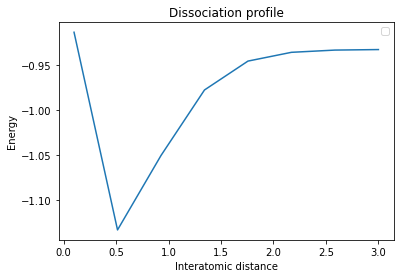

In [9]:
fig = plt.figure()
plt.plot(points,energies)
plt.legend()
plt.title('Dissociation profile')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

In [10]:
bs_res['energy']

[-0.9141496223820735,
 -1.132742431340317,
 -1.050442027287337,
 -0.9779959640850278,
 -0.9460488963169131,
 -0.9363511310448827,
 -0.9338791466765297,
 -0.9333082425417326]

In [11]:
from qiskit.chemistry.energy_surface_spline import EnergySurface1DSpline
energy_surface = EnergySurface1DSpline()

# fit data
xdata = bs_res['point']
ydata = bs_res['energy']
energy_surface.fit_to_data(xdata=xdata, ydata=ydata)

# newx = np.unique(xdata)
# newy = [np.average(ydata[np.where(xdata== val)[0][0]])
#          for val in np.unique(xdata)]
# print(newx)
# print(newy)
# print(xdata)
# print(ydata)
# # for val in np.unique(xdata):
# #     #print(val)
# #     print(np.where(xdata == val)[0])

(-1.1546017122361412, -0.8922903414862492)

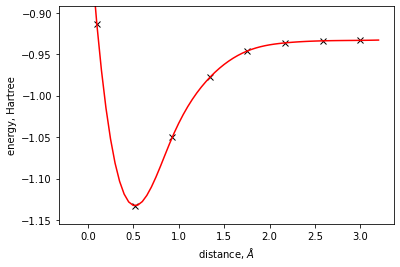

In [12]:
plt.plot(xdata, ydata, 'kx')
x = np.arange(min(xdata) - 0.25, max(xdata) + 0.25, 0.05)
plt.plot(x, energy_surface.eval(x), 'r-')
plt.xlabel(r'distance, $\AA$')
plt.ylabel('energy, Hartree')
dist = max(ydata) - min(ydata)
plt.ylim(min(ydata) - 0.1 * dist, max(ydata) + 0.1 * dist)